## DNA-encoded PROTACS targeting the proto-oncogenic transcription factor E2F1 

### TABLE OF CONTENTS

[type here]

### ABSTRACT

[type here]

### INTRODUCTION

[type here]

### METHODS

[type here]

**Plasmid-based PROTAC library**

In [ ]:
#gene cassette design here

In [ ]:
#Vector image stuff here

**Development of real-time luciferase-based degradation assay**

In [ ]:
#tiff stack gif movie thing here

In [ ]:
#DAPI image here

### RESULTS

[type here]

Setup - **DO NOT** run cell below or previously imported data will be lost if not local

In [13]:
### DO NOT RUN THIS CELL ###
### DO NOT RUN THIS CELL ###
### DO NOT RUN THIS CELL ###
### DO NOT RUN THIS CELL ###

import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pingouin as pg
import time
from IPython.display import display


#data imported is unaveraged triplicates, normalized by transfection efficiency; first column is time points
multipromotor_data = pd.read_csv("..\data\_normalized_to_mAz_Multipromotor_ALL.csv")

Create dataframes for means and standard deviations

In [ ]:
time_points = multipromotor_data['time'].tolist()

#create dfs with means and stds across triplicates; filter by regex with 2 since every third column in multipromotor_data ends in '2'
multipromotor_means = multipromotor_data.rolling(window=3, axis=1).mean().filter(regex=('2$'))
multipromotor_stds = multipromotor_data.rolling(window=3, axis=1).std().filter(regex=('2$'))

#clean column labels to be vanilla (e.g. CMV-mAZ vs CMV-mAZ.2)
for label, content in multipromotor_means.items():
    multipromotor_means.rename(columns={label:label.rstrip('.2')}, inplace = True)

for label, content in multipromotor_stds.items():
    multipromotor_stds.rename(columns={label:label.rstrip('.2')}, inplace = True)

#insert time points to first column of each dataframe
multipromotor_means.insert(0, 'time', time_points)
multipromotor_stds.insert(0, 'time', time_points)

Widget setup: create dicts for button names

In [3]:
#group selector button names : column name prefix' in dataframes
promotor_names = {'CMV':'CMV',
                  'CDC45':'CDC45-',
                  'CDC45_CHR_mutant':'CDC45mut',
                  'ORC1':'ORC1',
                  'BUB1': 'BUB1'}

#promotor group selector : list of column labels for that promotor dataset
promotor_dataset_labels = {}

for group_selector, group_prefix in promotor_names.items():
    promotor_dataset_labels[group_selector] = list(multipromotor_means.filter(regex=('^'+group_prefix)))

**Summary of preliminary PROTAC performance**

In [ ]:
pvalues_CMV = []
pvalues_mAz = []
for promoter, protac_list in promotor_dataset_labels.items():   #promoter name, list of PROTAC datasets for that promotor
    list_index = 0
    for protac in protac_list:  #individual protac data sets
        mwu_CMV = pg.mwu(x=multipromotor_means[protac], y=multipromotor_means[promotor_dataset_labels['CMV'][list_index]], alternative='less')  #dataframe with pengouin.mwu() stats, against CMV with same PROTAC
        mwu_mAz = pg.mwu(x=multipromotor_means[protac], y=multipromotor_means[promotor_dataset_labels[promoter][1]], alternative='less')  #dataframe with pengouin.mwu() stats, against mAz with same promotor
        pvalues_CMV.append(mwu_CMV.iloc[0]['p-val'])
        pvalues_mAz.append(mwu_mAz.iloc[0]['p-val'])
        list_index+=1
pvalues = pd.DataFrame()
pvalues.insert(0, 'dataset', multipromotor_means.columns[1:])
pvalues.insert(1, 'pvalues_CMV', pvalues_CMV)
pvalues.insert(2, 'pvalues_mAz', pvalues_mAz)
print(pvalues.head())


'''
fig1, ax1 = plt.subplots()
ax1.set_title('Analysis of covariance between overall PROTAC performance')
ax1.set_xlabel('p-value: significance from CMV analogue')
ax1.set_ylabel('p-value: significance from mAZ analogue')
for data in selected_data:
    plt.plot(multipromotor_means['time'], multipromotor_means[data], label=data)
    plt.fill_between(multipromotor_stds['time'], multipromotor_means[data] - 2 * multipromotor_stds[data], multipromotor_means[data] + 2 * multipromotor_stds[data], alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
'''

Widget creation: Interactive checkboxes to select datasets
(buttons select and deselect all within promotor set)

In [ ]:
# Create a dictionary to store the checkbox widgets
checkboxes = {}

# Create buttons for parents and checkboxes for children
for parent, children in promotor_dataset_labels.items():
    parent_button = widgets.Button(description=parent)
    children_checkboxes = [widgets.Checkbox(description=child) for child in children]
    checkboxes[parent] = {'parent': parent_button, 'children': children_checkboxes}

# Function to handle parent button click
def handle_parent_button_click(button):
    parent_data = checkboxes[button.description]
    parent_value = not all(checkbox.value for checkbox in parent_data['children'])
    with output_widget:
        for checkbox in parent_data['children']:
            checkbox.value = parent_value
            checkbox_style[checkbox.description] = parent_value

    parent_button_style = button_style[button.description]
    parent_button_style['selected'] = parent_value
    button.style.button_color = 'lightgreen' if parent_value else None

    update_output()

# Register the function to handle parent button click
for parent_data in checkboxes.values():
    parent_data['parent'].on_click(handle_parent_button_click)

# Function to handle child checkbox toggling
def handle_child_checkbox_toggle(change):
    checkbox = change['owner']
    parent_button = next((key for key, value in checkboxes.items() if checkbox in value['children']), None)
    if parent_button:
        parent_data = checkboxes[parent_button]
        parent_data['parent'].value = all(child.value for child in parent_data['children'])
    update_output()

# Register the function to handle child checkbox toggling
for parent_data in checkboxes.values():
    for checkbox in parent_data['children']:
        checkbox.observe(handle_child_checkbox_toggle, 'value')

# Store the button styles and checkbox styles
button_style = {parent: {'selected': False} for parent in checkboxes}
checkbox_style = {checkbox: False for parent in checkboxes for checkbox in checkboxes[parent]['children']}

# Display the checkboxes
checkboxes_widgets = []
for parent_data in checkboxes.values():
    parent_button = parent_data['parent']
    children_checkboxes = parent_data['children']
    checkboxes_widgets.append(widgets.VBox([parent_button] + children_checkboxes))

checkboxes_widget = widgets.HBox(checkboxes_widgets)
display(checkboxes_widget)

# Display the output list
output_widget = widgets.Output()
display(output_widget)

# Function to update the output list
def update_output():
    global selected_data
    selected_data = []
    for parent_data in checkboxes.values():
        for checkbox in parent_data['children']:
            if checkbox.value:
                selected_data.append(checkbox.description)
    with output_widget:
        output_widget.clear_output()
        print("Selected data:")
        if len(selected_data) > 0:
            for item in selected_data:
                print(item)
        else:
            print("No data selected.")

# Call the function initially to display the initial state
update_output()


Output()

**Noteable PROTACs**

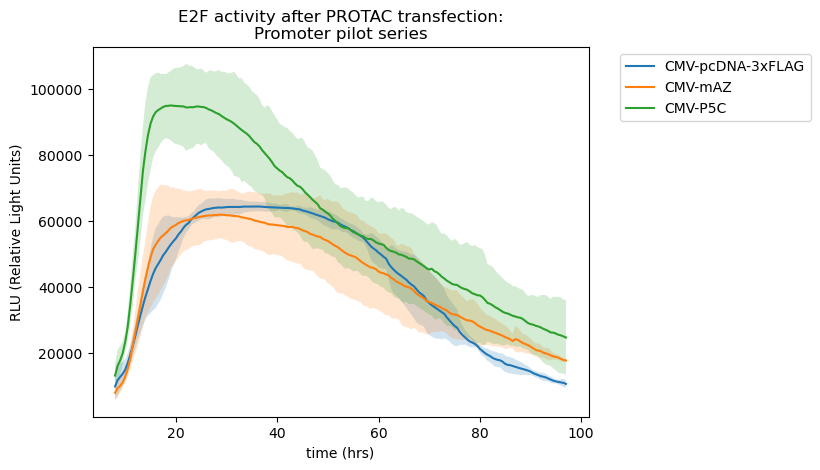

In [15]:
fig2, ax2 = plt.subplots()
ax2.set_title('E2F activity after PROTAC transfection:\nPromoter pilot series')
ax2.set_xlabel('time (hrs)')
ax2.set_ylabel('RLU (Relative Light Units)')
for data in selected_data:
    plt.plot(multipromotor_means['time'], multipromotor_means[data], label=data)
    plt.fill_between(multipromotor_stds['time'], multipromotor_means[data] - 2 * multipromotor_stds[data], multipromotor_means[data] + 2 * multipromotor_stds[data], alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

#save plot as png to local plot_pngs directory
file_name = '_'.join(selected_data)
timestamp = time.strftime("%Y%m%d-%H%M%S")  #prevents overwritting of saved plots and helps group plots created by time (why? why not)
fig2.savefig(("C:\\Users\\abarr\\OneDrive\\Git_Repos\\PROTAC-Research\\plot_pngs\\"+file_name+'_'+timestamp), bbox_inches='tight')  #bbox_inches='tight' prevents legend cutoff

### FUTURE DIRECTIONS

[type here]